#Set enviornment and networks

**Import libraries and datasets:**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

#Input Keras and Tensorflow Environment
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, utils, regularizers, applications, optimizers
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

print("\nEnviornments imported")
folder = './dataset/'
!unzip -q "./drive/My Drive/dataset-v3.zip" -d "dataset"

print("\nDataset loaded")

**Build CNN Structure:**

In [ ]:
print("1. Create model: \n")

nclasses = 13

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(nclasses,activation='softmax'))

episodes = 100   
learning_rate = 0.001

opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])

checkpoint_path = "ckpoint_cnn_model/cnn_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

model.save('cnn_model.h5')
model.summary()

**Load pre-trained VGG19 and add top layers:**

In [ ]:

print("1. Create model: \n")

print("Loading pretrained VGG19 model... \n")

base_model = applications.vgg19.VGG19(weights='imagenet',include_top=False)
model = models.Sequential()

x = base_model.output

print("Model loaded")

print("Add trainable layers for fine tunning: ")

nclasses = 13

x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(1024,activation='relu')(x)             #Dense layer 1
x=layers.Dropout(0.5)(x)
x=layers.Dense(1024,activation='relu')(x)             #Dense layer 2
x=layers.Dropout(0.4)(x)
preds=layers.Dense(nclasses,activation='softmax')(x)  #Final layer with softmax activation

model = models.Model(inputs=base_model.input,outputs=preds)


#Freeze base layers
for layer in model.layers[:-9]:
    layer.model=False
for layer in model.layers[-9:]:
    layer.trainable=True
    
episodes = 100    
learning_rate = 0.001

checkpoint_path = "ckpoint_vggmodel/vgg19_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

model.save('vggmodel19.h5')

**Load Existing Network:**

In [ ]:
folder_model = 'vgg19_dataset1.h5'
model = models.load_model(folder_model)

from tensorflow.keras.optimizers import SGD
    
episodes = 100   
learning_rate = 0.001

opt = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

checkpoint_path = "ckpoint_vggmodel/vgg19_model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

print("\n",len(model.layers))
model.save('vgg19_tfm.h5')

# Training

**Load dataset and perform Data Augmentation:**

In [ ]:
print("2. Create dataset:\n")

train_folder = folder + 'train'
test_folder = folder + 'validate'

print(train_folder)
print(test_folder)

datagen = image.ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=90,
                                width_shift_range=0.00,
                                height_shift_range=0.00,
                                brightness_range=[0.7,1.0],
                                horizontal_flip=True)

train = datagen.flow_from_directory(
                                directory=train_folder,
                                target_size=(224, 224),
                                color_mode="rgb",
                                batch_size=64,
                                class_mode="sparse",
                                shuffle=True)

validate = datagen.flow_from_directory(
                                directory=test_folder,
                                target_size=(224, 224),
                                color_mode="rgb",
                                batch_size=64,
                                class_mode="sparse",
                                shuffle=True)

clases = ["-", "BB", "BK", "BN", "BP", "BQ", "BR", "WB", "WK", "WN", "WP", "WQ", "WR"]

label_map = (validate.class_indices)

print(label_map)

**Start training:**

In [ ]:
print("3. Train model:\n")

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train, epochs=episodes,
                    validation_data=validate,
                    callbacks=[cp_callback])

import numpy as np
x = np.zeros((len(np.array(history.history['acc'])),4))

x[:,0] = np.array(history.history['acc'])
x[:,1] = np.array(history.history['val_acc'])
x[:,2] = np.array(history.history['loss'])
x[:,3] = np.array(history.history['val_loss'])

np.savetxt("drive/My Drive/TFM/loss_history_vgg_set2_100epochs.txt", x, delimiter=",")

model.save('modeltrained.h5')


**Save results:** 

In [ ]:
import numpy as np
x = np.zeros((len(np.array(history.history['acc'])),4))

x[:,0] = np.array(history.history['acc'])
x[:,1] = np.array(history.history['val_acc'])
x[:,2] = np.array(history.history['loss'])
x[:,3] = np.array(history.history['val_loss'])

np.savetxt("loss_history.txt", x, delimiter=",")

In [ ]:
#Check training results

#Plot training & validation accuracy values

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

**Test Network without Data Augmentation:**

In [ ]:
datagen_test = image.ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=0,
                                width_shift_range=0.00,
                                height_shift_range=0.00)
                                

test = datagen_test.flow_from_directory(
                                directory=test_folder,
                                target_size=(224, 224),
                                color_mode="rgb",
                                batch_size=64,
                                class_mode="sparse",
                                shuffle=True,
                                seed=42)
  

Found 2353 images belonging to 13 classes.


In [ ]:
total_acc = []


for i in range(0,20):

    test_img, test_labels = test.next()
    test_dataset = tf.data.Dataset.from_tensor_slices((test_img, test_labels))
    test_dataset = test_dataset.batch(50)

    test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
    total_acc.append(test_acc)

import statistics
print(statistics.median(total_acc))

**Show prediction example:**

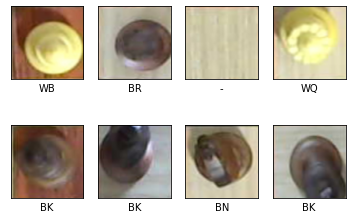

In [ ]:
plt.figure()
test_img, test_labels = test.next()
pred = model.predict(test_img)
ind = np.argmax(pred,axis=1)

for i in range(0,8):
  lbl = ind[i]
  plt.subplot(2,4,i+1)
  plt.imshow(test_img[i])
  plt.xticks([])
  plt.yticks([])
  plt.xlabel(clases[lbl])
  plt.grid(False)

plt.show()